In [2]:
import pickle as pkl
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from figrid.data_container import DataContainer

pplib.imports()
COSMO = '/Users/cosinga/overleaf/hi_cosmo/figures/'

In [56]:
ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/5-18_pkdatasort.pkl', 'rb'))
print(ds.getAttrs())

ds.tickArgs(direction = 'in', right = True, top = True, labelsize = 14)
ds.legendArgs(frameon = False, loc = 'upper right', fontsize = 14, slc = (-1, -1))

ds.axisLabelArgs('both', fontsize = 16)
ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 16, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 16, ha = 'center' , va = 'top')
ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.04, 10])

ds.setOrder('space', ['real', 'redshift', 'rsd'])

ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
ds.displayAs('color', ['blue', 'red', 'resolved'], 
             ['Blue Gal.', 'Red Gal.', 'All Gal.'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Particles in Galaxies'])

ds.setColors('HI_fieldname', ['firebrick', 'saddlebrown', 'sandybrown'], ['vn', 'hiptl', 'hisubhalo'])
ds.setColors('color', ['red', 'blue', 'gray'], ['red', 'blue', 'resolved'])

ds.setXLabel(pplib.wnum())
print(ds.getAttrVals('post_process'))
print(ds.getAttrVals('fieldname'))

['path', 'result_type', 'result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'color', 'gal_species', 'gal_res', 'color_cut', 'ptl_species', 'map', 'model', 'HI_fieldname', 'projection', 'HI_res', 'censat', 'post_process', 'numerator', 'denominator']
['no key found', 'theory_bias', 'obs_bias', 'corr_coef']
['galaxy', 'hiptl_ptl', 'hiptl', 'vn_galaxy', 'hiptl_galaxy', 'galaxy_dust', 'vn_ptl', 'vn', 'ptl', 'hisubhalo_ptl', 'hisubhalo_galaxy', 'hisubhalo', 'galaxy_ptl', 'hisubhalo_galaxy_dust']


In [57]:
def calc_obs_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    auto = ds.getMatching(ip)
    biases = []
    for i in range(len(auto)):
        
        data = [auto[i].data[0], np.sqrt(auto[i].data[1] / ptl_auto.data[1])]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(auto[i].attrs))
        dc.add('post_process','obs_bias')
        dc.add('is_auto', False)
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')

        biases.append(dc)
    return biases

def calc_th_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    cross = ds.getMatching(ip)
    biases = []
    for i in range(len(cross)):
        
        data = [cross[i].data[0], cross[i].data[1] / ptl_auto.data[1]]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(cross[i].attrs))
        dc.add('post_process','theory_bias')
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')
        biases.append(dc)
    return biases
def save_bias(biases):
    SAVE_ATTRS = ['simname', 'snapshot', 'space', 'post_process', 'color', 'model']
    bvals = []
    for bias in biases:
        bval = bias.getData()[1][1]
        attrs = [bias.get(attr) for attr in SAVE_ATTRS]
        bvals.append([bval, attrs])
    return bvals

In [58]:
simnames = ['tng100', 'tng300']
snapshots = [50, 67, 99]
spaces = ['real', 'redshift']
bvals = []
for name in simnames:
    for snap in snapshots:
        for space in spaces:
            
            if not (snap == 67 and name == 'tng300'):
                print("\n", name, snap, space)
                hiip = {'is_auto':True, "HI_fieldname":['vn', 'hiptl'],      
                  'axis':0, 'grid_resolution':800, 'simname': name,
                  'mas':'CICW', 'snapshot':snap, 'space':space,
                 'path':'fiducial', 'post_process':'no key found'}
                obs_biases = calc_obs_bias(hiip)
                print('hi biases:', len(obs_biases))
                ds.extend(obs_biases)
                bvals.extend(save_bias(obs_biases))
                galip = {'gal_res':'diemer',
                          'gal_species':'stmass', 'sim_resolution':'high', 
                         'axis':0, 'grid_resolution':800,
                          'censat':['no key found', 'both'], 'mas':'CICW', 
                         'color': ['blue', 'red', 'resolved'], 'fieldname':'galaxy',
                         'path':'fiducial', 'simname':name, 'space':space,
                        'snapshot':snap, 'post_process':'no key found'}
                obs_biases = calc_obs_bias(galip)
                print('galaxy biases:', len(obs_biases))
                bvals.extend(save_bias(obs_biases))
                ds.extend(obs_biases)


 tng100 50 real
hi biases: 5
galaxy biases: 3

 tng100 50 redshift
hi biases: 5
galaxy biases: 3

 tng100 67 real
hi biases: 5
galaxy biases: 3

 tng100 67 redshift
hi biases: 5
galaxy biases: 3

 tng100 99 real
hi biases: 5
galaxy biases: 3

 tng100 99 redshift
hi biases: 5
galaxy biases: 3

 tng300 50 real
found too many particles
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.703163862228394, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high', 'num_part': 2740098112, 'grid_resolution': 800, 'snapshot': 50, 'redshift': 0.9972942257819404, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': True, 'compute_slice': False, 'ptl_species': 'ptl'}
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.2175133228302, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high'

In [59]:
simnames = ['tng100', 'tng300']
snapshots = [50, 67, 99]
spaces = ['real', 'redshift']

for name in simnames:
    for snap in snapshots:
        for space in spaces:
            
            if not (snap == 67 and name == 'tng300'):
                print("\n", name, snap, space)
                hiip = {'is_auto':False, "fieldname":['vn_ptl', 'hiptl_ptl'],      
                  'axis':0, 'grid_resolution':800, 'simname': name,
                  'mas':'CICW', 'snapshot':snap, 'space':space,
                 'path':'fiducial', 'post_process':'no key found',
                       'ptl_species':['no key found', 'ptl']}
                th_biases = calc_th_bias(hiip)
                print('hi biases:', len(th_biases))
                ds.extend(th_biases)
                bvals.extend(save_bias(th_biases))
                galip = {'gal_res':'diemer',
                      'gal_species':'stmass', 'sim_resolution':'high', 
                     'axis':0, 'grid_resolution':800,
                      'censat':['no key found', 'both'], 'mas':'CICW', 
                     'color': ['blue', 'red', 'resolved'], 'fieldname':'galaxy_ptl',
                     'path':'fiducial', 'simname':name, 'space':space,
                    'snapshot':snap, 'post_process':'no key found', 'ptl_species':['ptl', 'no key found']}
                th_biases = calc_th_bias(galip)
                print('galaxy biases:', len(th_biases))
                bvals.extend(save_bias(th_biases))

                ds.extend(th_biases)


 tng100 50 real
hi biases: 5
galaxy biases: 2

 tng100 50 redshift
hi biases: 5
galaxy biases: 2

 tng100 67 real
hi biases: 5
galaxy biases: 2

 tng100 67 redshift
hi biases: 5
galaxy biases: 2

 tng100 99 real
hi biases: 5
galaxy biases: 2

 tng100 99 redshift
hi biases: 5
galaxy biases: 2

 tng300 50 real
found too many particles
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.703163862228394, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high', 'num_part': 2740098112, 'grid_resolution': 800, 'snapshot': 50, 'redshift': 0.9972942257819404, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': True, 'compute_slice': False, 'ptl_species': 'ptl'}
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.2175133228302, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high'

The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]


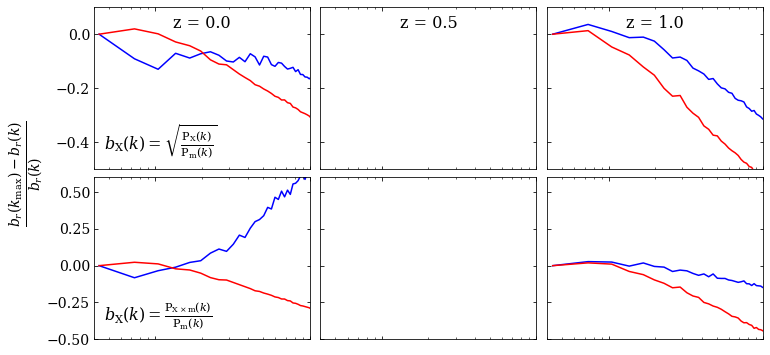

In [62]:
combine_rr = True

ip = {'is_auto':False, 
      'axis':0, 'grid_resolution':800, 'simname': ['tng300'], 'gal_res':'diemer',
      'gal_species':'stmass','ptl_species':['ptl', 'no key found'],
      'censat':['no key found', 'both'], 'mas':'CICW', 'color': ['red', 'blue'],
      'post_process':['obs_bias', 'theory_bias'], 'snapshot':[99, 67, 50], 'space':'real',
     'path':'fiducial', 'denominator':'ptl', '_post_time':'now'}

def plot_err(ax, data, kwargs):
    x = data[0]
    y = data[1]
    ylin = y[0]
    yerr = (ylin - y) / y
    ax.plot(x, yerr, **kwargs)
    
    return
    
bfg = ds.figrid('color', 'post_process', 'snapshot', ip)

bfg.setFunc({}, plot_err)
gspec = {'wspace':0.05, 'hspace':0.05, 'xborder':[0.4, 0]}
fn = 'k'
name1 = '\\mathrm{X}'
name2 = '\\mathrm{m}'
obsbias = '$b_{%s}(k) = \\sqrt{\\frac{\\mathrm{P}_{%s} (%s)}{\\mathrm{P}_{%s} (%s)}}$'%(name1, name1, fn, name2, fn)
thbias = '$b_{%s}(k) = \\frac{\\mathrm{P}_{%s \\times %s} (%s)}{\\mathrm{P}_{%s} (%s)}$'%(name1, name1, name2, fn, name2, fn)

bfg.setPanelsize(3, 2.25)
bfg.gspecArgs(yborder = [0.05, 0.25], **gspec)
bfg.axisArgs(yscale = 'linear', xlim = (.04, 1))
bfg.axisArgs(slc = 'obs_bias', ylim = (-0.5, 0.1))
bfg.axisArgs(slc = 'theory_bias', ylim = (-0.5, 0.6))
bfg.setDefaultTicksParams()
bfg.rowLabels([obsbias, thbias])
bfg.legendArgs(rm_legend = True)
bfg.setYLabel(r"$\frac{b_r (k_{\mathrm{max}}) - b_r (k)}{b_r (k)}$", fontsize = 20)
# bfg.rowLabelArgs(va = 'bottom')
if combine_rr:
    bfg.tickArgs(labelbottom = False)
    bfg.setXLabel('')
else:
    bfg.setXLabel(pplib.wnum())
bfg.plot()

The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]


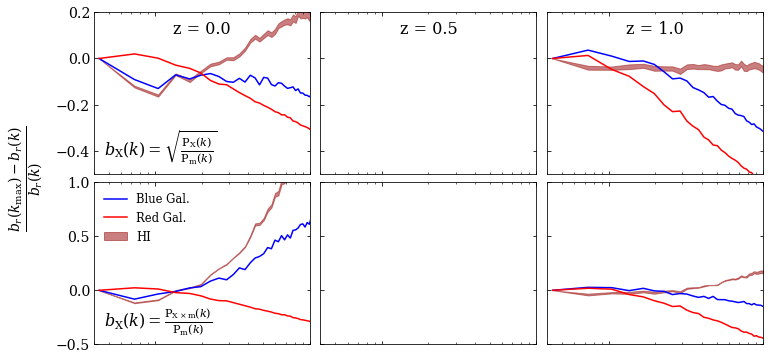

<Figure size 810x540 with 0 Axes>

In [63]:
def add_hi_real(bfg):
    ip = {'is_auto':False, 
          'axis':0, 'grid_resolution':800, 'simname': ['tng300'],
          'HI_fieldname':['vn', 'hiptl'],'ptl_species':['ptl', 'no key found'],
          'censat':['no key found', 'both'], 'mas':'CICW',
          'post_process':['obs_bias', 'theory_bias'], 'snapshot':[99, 67, 50], 'space':'real',
         'path':'fiducial', 'denominator':'ptl', 'numerator':'no key found'}
    hifg = ds.figrid("simname", 'post_process', 'snapshot', ip)
    hifg.rowLabels(["", ""])
    hifg.colLabels([""]*4)
    nrows, ncols = hifg.panels.shape
    for i in range(nrows):
        for j in range(ncols):
            for dc in hifg.panels[i, j]:
                    data = dc.getData()
                    x = data[0]; y = data[1]
                    ylin = y[0]
                    yerr = (ylin - y) / y
                    dc.setData([x, yerr])
    hifg.plotArgs({'simname':'tng300'}, color = 'brown', label = 'HI')
    hifg.axisArgs(yscale = 'linear', xlim = (.04, 1))
    hifg.axisArgs(slc = 'obs_bias', ylim = (-0.5, 0.2))
    hifg.axisArgs(slc = 'theory_bias', ylim = (-0.5, 1))
    hifg.autoFill(alpha = 0.6)
    hifg.legendArgs(slc = (1,0), loc = 'upper left', fontsize = 11.5)
    hifg.plot(axes = bfg.axes)
    real_bfg = bfg
    if not combine_rr:
        bfg.save(COSMO + 'bias_tng100-300_real_hbr_placeholder.png')
    return
add_hi_real(bfg)
real_fg = bfg
bfg.fig

The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]


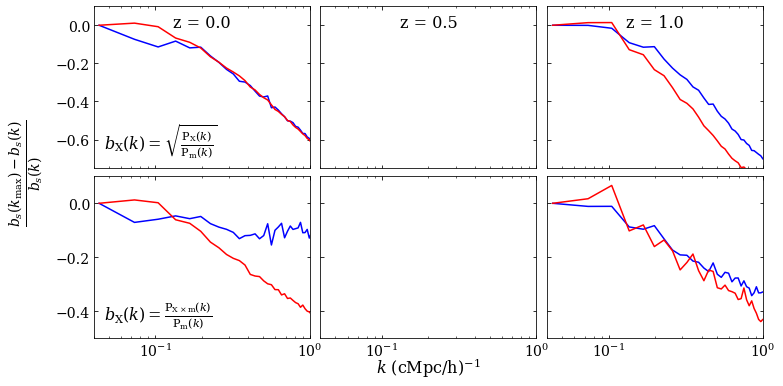

In [66]:
combine_rr = True

ip = {'is_auto':False, 
      'axis':0, 'grid_resolution':800, 'simname': ['tng300'], 'gal_res':'diemer',
      'gal_species':'stmass','ptl_species':['ptl', 'no key found'],
      'censat':['no key found', 'both'], 'mas':'CICW', 'color': ['red', 'blue'],
      'post_process':['obs_bias', 'theory_bias'], 'snapshot':[99, 67, 50], 'space':'redshift',
     'path':'fiducial', 'denominator':'ptl', '_post_time':'now'}

def plot_err(ax, data, kwargs):
    x = data[0]
    y = data[1]
    ylin = y[0]
    yerr = (ylin - y) / y
    ax.plot(x, yerr, **kwargs)
    
    return
    
bfg = ds.figrid('color', 'post_process', 'snapshot', ip)

bfg.setFunc({}, plot_err)
gspec = {'wspace':0.05, 'hspace':0.05, 'xborder':[0.4, 0]}
fn = 'k'
name1 = '\\mathrm{X}'
name2 = '\\mathrm{m}'
obsbias = '$b_{%s}(k) = \\sqrt{\\frac{\\mathrm{P}_{%s} (%s)}{\\mathrm{P}_{%s} (%s)}}$'%(name1, name1, fn, name2, fn)
thbias = '$b_{%s}(k) = \\frac{\\mathrm{P}_{%s \\times %s} (%s)}{\\mathrm{P}_{%s} (%s)}$'%(name1, name1, name2, fn, name2, fn)

bfg.setPanelsize(3, 2.25)
bfg.gspecArgs(yborder = [0.05, 0.25], **gspec)
bfg.axisArgs(yscale = 'linear', xlim = (.04, 1))
bfg.axisArgs(slc = 'obs_bias', ylim = (-0.75, 0.1))
bfg.axisArgs(slc = 'theory_bias', ylim = (-0.5, 0.1))
bfg.setDefaultTicksParams()
bfg.rowLabels([obsbias, thbias])
bfg.legendArgs(rm_legend = True)
bfg.setYLabel(r"$\frac{b_s (k_{\mathrm{max}}) - b_s (k)}{b_s (k)}$", fontsize = 20)
# bfg.rowLabelArgs(va = 'bottom')
bfg.setXLabel(pplib.wnum())
bfg.plot()

The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]


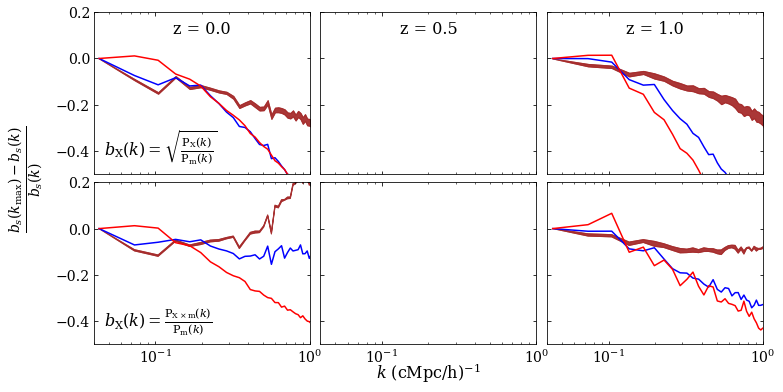

<Figure size 810x540 with 0 Axes>

In [69]:
def add_hi_red(bfg):
    ip = {'is_auto':False, 
          'axis':0, 'grid_resolution':800, 'simname': ['tng300'],
          'HI_fieldname':['vn', 'hiptl'],'ptl_species':['ptl', 'no key found'],
          'censat':['no key found', 'both'], 'mas':'CICW',
          'post_process':['obs_bias', 'theory_bias'], 'snapshot':[99, 67, 50], 'space':'redshift',
         'path':'fiducial', 'denominator':'ptl', 'numerator':'no key found'}
    hifg = ds.figrid("simname", 'post_process', 'snapshot', ip)
    hifg.rowLabels(["", ""])
    hifg.colLabels([""]*4)
    nrows, ncols = hifg.panels.shape
    for i in range(nrows):
        for j in range(ncols):
            for dc in hifg.panels[i, j]:
                    data = dc.getData()
                    x = data[0]; y = data[1]
                    ylin = y[0]
                    yerr = (ylin - y) / y
                    dc.setData([x, yerr])
    hifg.plotArgs({'simname':'tng300'}, color = 'brown', label = 'HI')
    hifg.axisArgs(yscale = 'linear', xlim = (.04, 1))
    hifg.axisArgs(slc = 'obs_bias', ylim = (-0.5, 0.2))
    hifg.axisArgs(slc = 'theory_bias', ylim = (-0.5, 0.2))
    hifg.autoFill(alpha = 0.6)
#     hifg.legendArgs(slc = (1,0), loc = 'upper left', fontsize = 11.5)
    hifg.legendArgs(rm_legend = True)
    hifg.plot(axes = bfg.axes)
    real_bfg = bfg
    if not combine_rr:
        bfg.save(COSMO + 'bias_tng100-300_real_hbr_placeholder.png')
    return
add_hi_red(bfg)
bfg.fig

The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]
The row values for post_process: ['obs_bias', 'theory_bias']
The column values for snapshot: [99, 67, 50]


/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_38443/3122575403.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


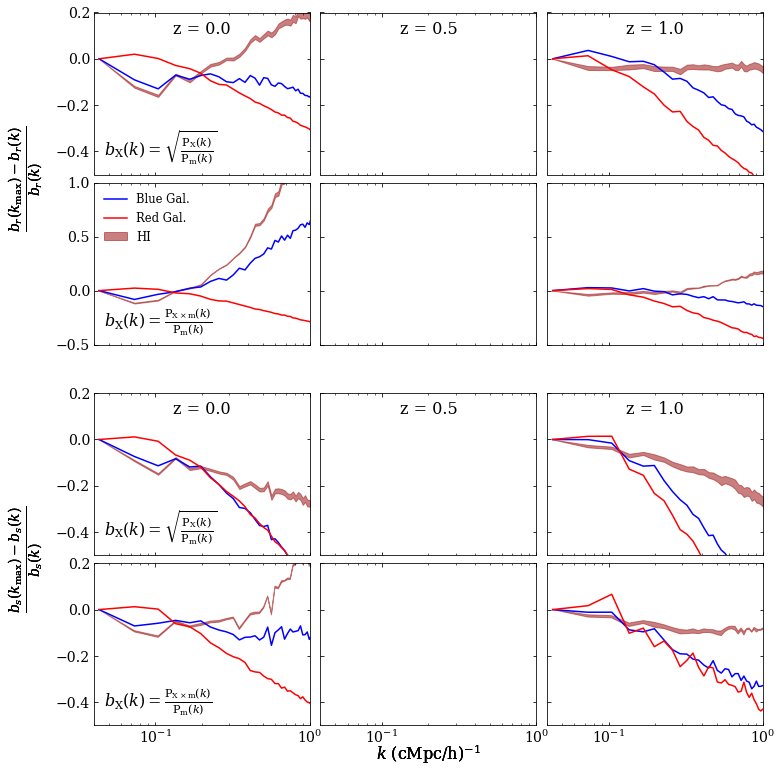

<Figure size 810x540 with 0 Axes>

<Figure size 810x540 with 0 Axes>

In [71]:
if combine_rr:
    figarr = np.empty((2, 1), dtype = object)
    figarr[0, 0] = real_fg
    figarr[1, 0] = bfg
    fig = bfg.combine(figarr)
    add_hi_real(real_fg)
    add_hi_red(bfg)
    fig.show()
    fig.savefig(COSMO + "bias_scaledep_tng300_hbr_placeholder.png", bbox_inches = 'tight')

# Presentation - nonlinear correlation coefficients

The row values for snapshot: [99]
The column values for : ['no key found']


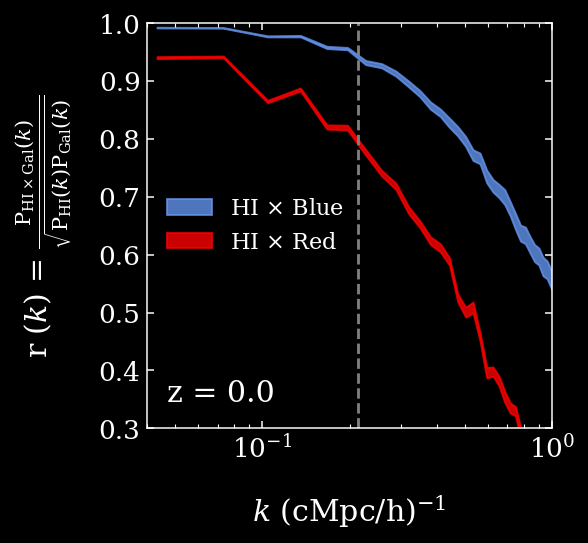

In [35]:
ip = {'is_auto':False, 'post_process':'corr_coef', 'HI_fieldname':['vn', 'hiptl'], 'space':'redshift', 'gal_res':'diemer',
      'gal_species':'stmass', 'snapshot':[99], 'simname':['tng300'],
      'censat':['no key found', 'both'], 'mas':'CICW', 'color': ['red', 'blue'],
     'path':['fiducial']}
fg = ds.figrid('color', 'snapshot', '', ip)
fg.axisArgs(yscale = 'linear', ylim = (0.3, 1), xlim = (.04, 1))
fg.plotArgs({'color':'blue'}, color = 'cornflowerblue', label = 'HI $\\times$ Blue')
fg.plotArgs({'color':'red'}, color = 'red', label = 'HI $\\times$ Red')
fg.gspecArgs(xborder = [0.33, 0])
fg.setYLabel(pplib.cclab('HI', 'Gal'))
fg.autoFill(alpha = 0.8)
fg.figArgs(dpi = 135)
fg.legendArgs(rm_legend = False, loc = 'center left', fontsize = 12)
pplib.darkmode(fg)
fg.plot()
fg.axes[0,0].axvline(0.71 * 0.3, color = 'gray', linestyle = 'dashed')

The row values for : ['no key found']
The column values for simname: ['tng300']


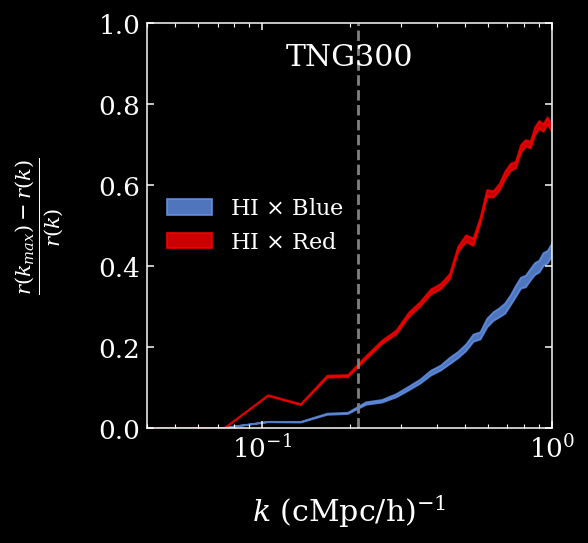

In [52]:
def plot_err(ax, data, kwargs):
    x = data[0]
    y = data[1]
    ylin = y[0]
    yerr = (ylin - y) / y
    print(yerr)
    kwargs['alpha'] = 1
    ax.plot(x, yerr, **kwargs)
    return
ip = {'is_auto':False, 'post_process':'corr_coef', 'HI_fieldname':['vn', 'hiptl'], 'space':'redshift', 'gal_res':'diemer',
      'gal_species':'stmass', 'snapshot':[99], 'simname':['tng300'],
      'censat':['no key found', 'both'], 'mas':'CICW', 'color': ['red', 'blue'],
     'path':['fiducial']}
fg = ds.figrid('color', '', 'simname', ip)
data = fg.panels[0,0]
for dc in data:
    data = dc.getData()
    x = data[0]; y = data[1]
    ylin = y[0]
    yerr = (ylin - y) / ylin
    dc.setData([x, yerr])
fg.axisArgs(yscale = 'linear', ylim = (0, 1), xlim = (.04, 1))
fg.colLabels(['TNG300'])
fg.plotArgs({'color':'blue'}, color = 'cornflowerblue', label = 'HI $\\times$ Blue')
fg.plotArgs({'color':'red'}, color = 'red', label = 'HI $\\times$ Red')
fg.gspecArgs(xborder = [0.33, 0])
fg.setYLabel(r"$\frac{r(k_{max}) - r(k)}{r(k)}$", fontsize = 16)
fg.autoFill(alpha = 0.8)
# fg.setFunc({'figrid_process':'fill'}, plot_err)

fg.figArgs(dpi = 135)
fg.legendArgs(rm_legend = False, loc = 'center left', fontsize = 12)
pplib.darkmode(fg)
fg.plot()
fg.axes[0,0].axvline(0.71 * 0.3, color = 'gray', linestyle = 'dashed')